#  Model Training, Evaluation & Resampling 

This notebook will contain the model training process, evaluation:

- Model selection using H2O AutoML  
- Splitting data into train/test sets  
- Model training, evaluation, and cross-validation  
- Hyperparameter tuning  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter
import os

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

In [3]:
path = '/Users/hwangyinung/Downloads/heart_2020_cleaned.csv'
df = pd.read_csv(path)
df.sample(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
260101,No,22.86,No,No,No,0.0,0.0,No,Female,35-39,Asian,No,Yes,Excellent,7.0,No,No,No
106057,No,22.50,No,No,No,2.0,5.0,No,Male,25-29,White,No,Yes,Very good,7.0,No,No,No
62769,No,22.71,Yes,No,No,0.0,0.0,No,Male,75-79,White,No,Yes,Very good,8.0,No,No,Yes
169342,No,23.63,No,No,No,0.0,0.0,No,Male,70-74,White,No,Yes,Excellent,7.0,No,No,Yes
11288,No,30.42,No,No,No,0.0,0.0,No,Female,25-29,White,No,Yes,Good,8.0,No,No,No


In [4]:
df_encoded = df.copy()
for column in df.columns:
    if df[column].dtype == 'object':
        df_encoded[column] = LabelEncoder().fit_transform(df[column])

In [5]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']
print("原始類別分布：", Counter(y))

原始類別分布： Counter({0: 292422, 1: 27373})


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
X_train_small = X_train[:20000]
y_train_small = y_train[:20000]

samplers = {
    'SMOTE': SMOTE(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

output_dir = "resampling_output"
os.makedirs(output_dir, exist_ok=True)

results = {}
feature_maps = {}

In [8]:
for name, sampler in samplers.items():
    print(f"\n執行 {name} ...")
    X_res, y_res = sampler.fit_resample(X_train_small, y_train_small)

    print(f"{name} 前樣本數：{len(y_train_small)}")
    print(f"{name} 後樣本數：{len(y_res)}")
    print(f"{name} 類別分布：{Counter(y_res)}")

    model = RandomForestClassifier(n_estimators=30, max_depth=8, n_jobs=-1, random_state=42)
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"=== {name} 分類報告 ===")
    print(classification_report(y_test, y_pred))

    results[name] = {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"]
    }

    df_bal = pd.DataFrame(X_res, columns=X.columns)
    df_bal["HeartDisease"] = y_res
    df_bal.to_csv(f"{output_dir}/train_data_{name.lower()}.csv", index=False)

    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title(f"Feature Importance - {name}")
    plt.bar(range(len(importances)), importances[sorted_idx])
    plt.xticks(range(len(importances)), X.columns[sorted_idx], rotation=90)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_importance_{name.lower()}.png")
    plt.close()

    feature_maps[name] = importances


執行 SMOTE ...
SMOTE 前樣本數：20000
SMOTE 後樣本數：36592
SMOTE 類別分布：Counter({0: 18296, 1: 18296})
=== SMOTE 分類報告 ===
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     58484
           1       0.25      0.62      0.36      5475

    accuracy                           0.81     63959
   macro avg       0.61      0.72      0.62     63959
weighted avg       0.90      0.81      0.84     63959


執行 BorderlineSMOTE ...
BorderlineSMOTE 前樣本數：20000
BorderlineSMOTE 後樣本數：36592
BorderlineSMOTE 類別分布：Counter({0: 18296, 1: 18296})
=== BorderlineSMOTE 分類報告 ===
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     58484
           1       0.25      0.63      0.36      5475

    accuracy                           0.81     63959
   macro avg       0.61      0.73      0.62     63959
weighted avg       0.90      0.81      0.84     63959


執行 ADASYN ...
ADASYN 前樣本數：20000
ADASYN 後樣本數：36258
ADASYN 類別分布：Counter({0: 18296

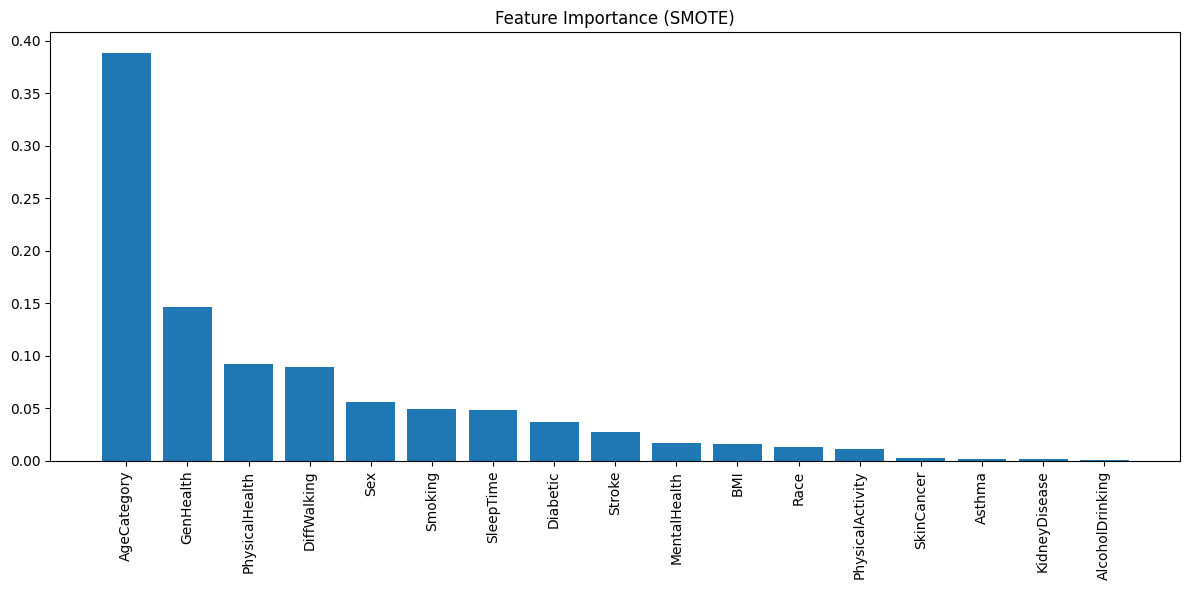

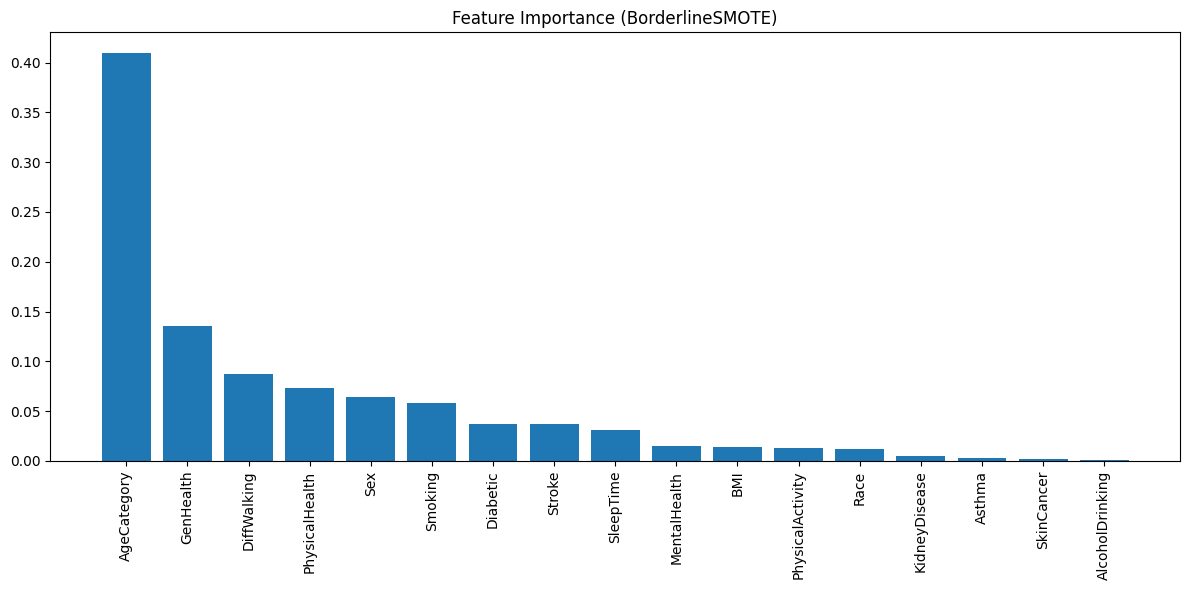

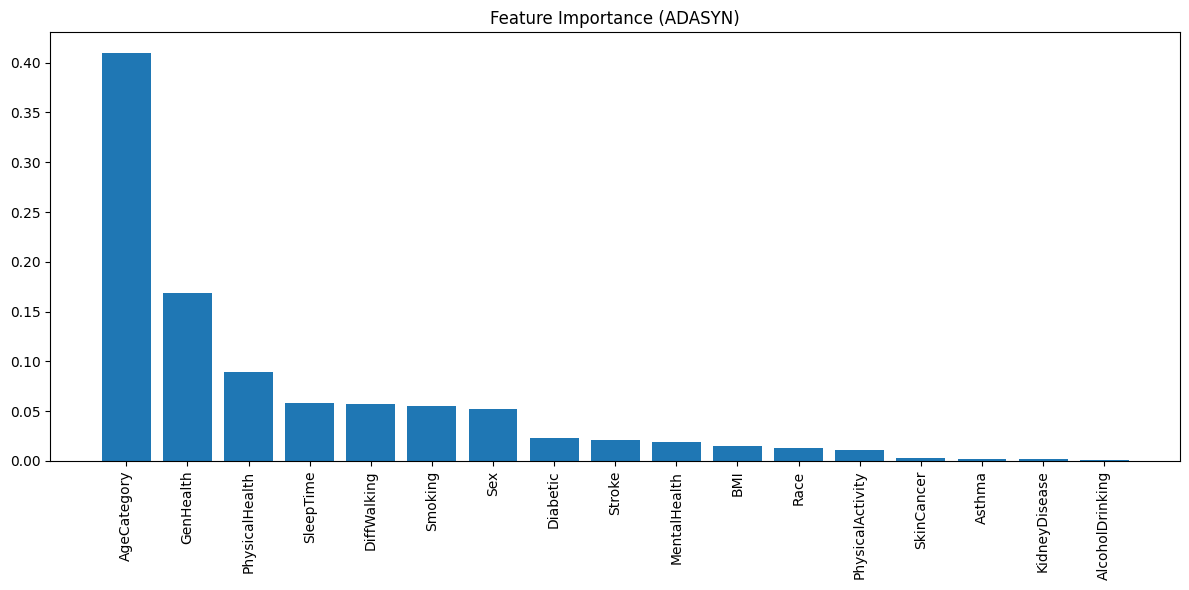

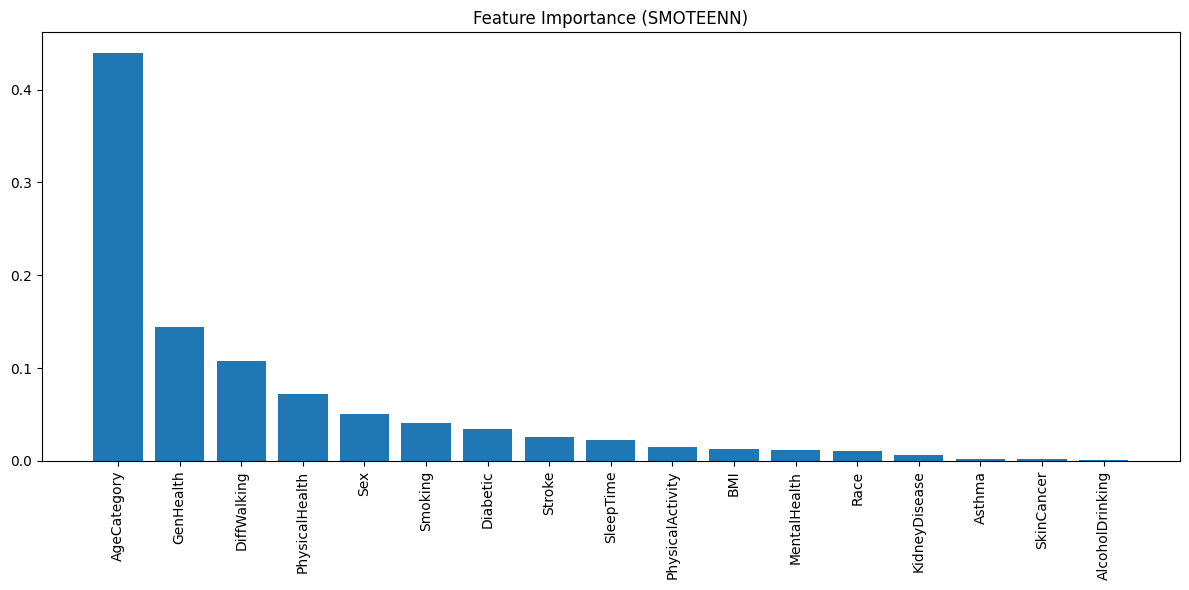

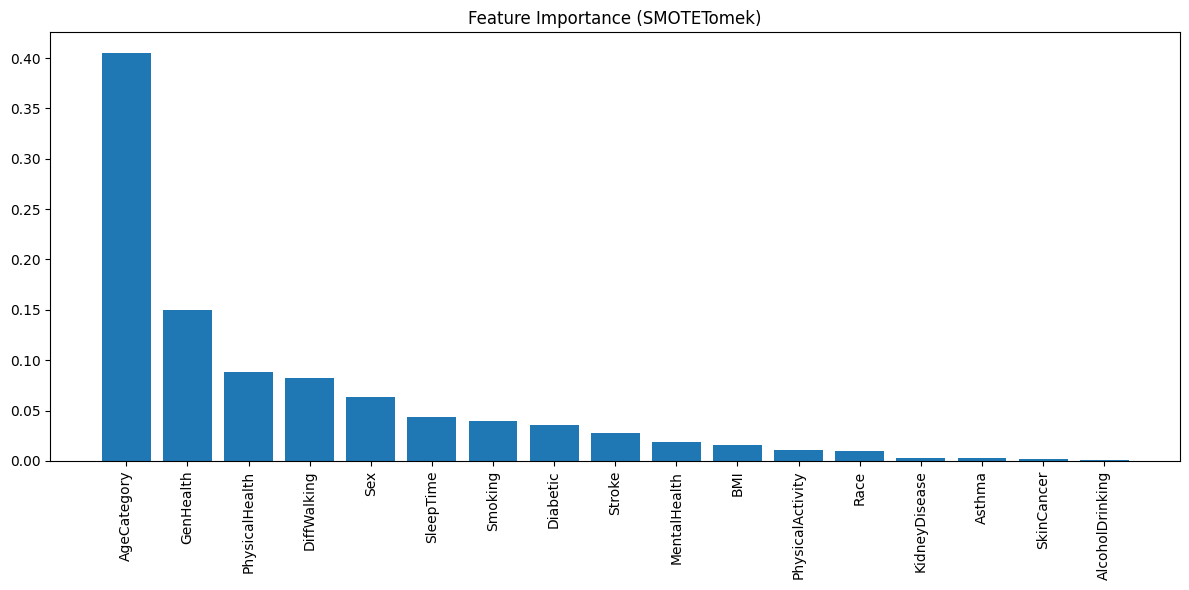

In [10]:
# 顯示 Feature Importance
for name, importances in feature_maps.items():
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance ({name})")
    plt.bar(range(len(importances)), importances[sorted_idx])
    plt.xticks(range(len(importances)), X.columns[sorted_idx], rotation=90)
    plt.tight_layout()
    plt.show()

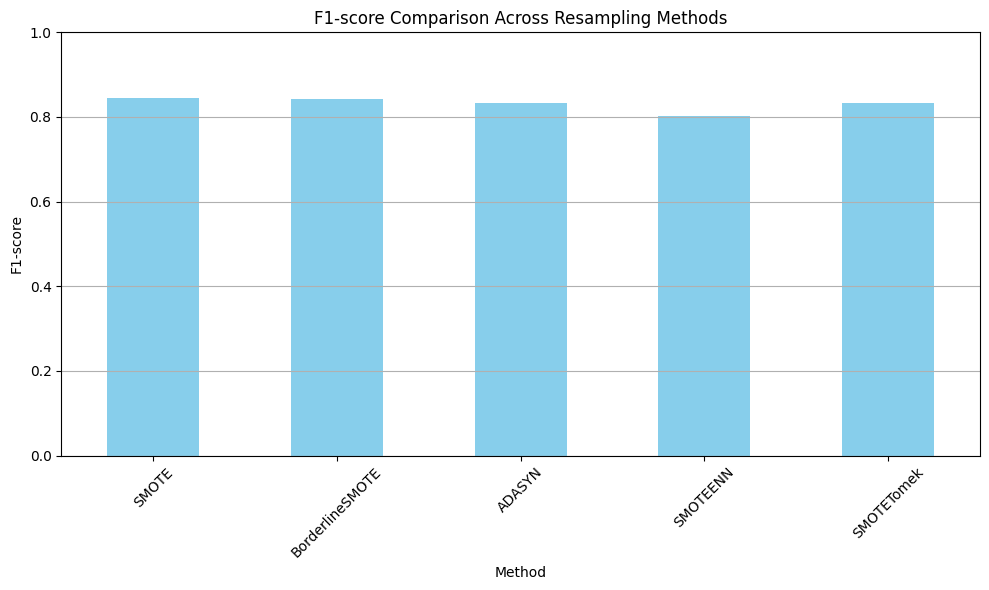

In [11]:
df_result = pd.DataFrame(results).T
df_result.index.name = "Method"
df_result.to_csv(f"{output_dir}/resampling_comparison.csv")
df_result.to_excel(f"{output_dir}/resampling_comparison.xlsx")

plt.figure(figsize=(10, 6))
df_result["f1-score"].plot(kind='bar', color='skyblue')
plt.title("F1-score Comparison Across Resampling Methods")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f"{output_dir}/f1_score_comparison.png")
plt.show()